# Hyperparameter Tuning

Hyperparameter tuning is the process of tweaking values to achieve the best result for a function. 

In the previous lesson we have created our first basic algorithm, which already achieved some amount of money. Our goal of this lesson is to maximize the profit with a trial and error approach of trying out different values. 

Let us first recreate the results of last lesson:

[*********************100%***********************]  1 of 1 completed
2020-05-22 00:00:00  Buying stock for 79.72$
2020-07-28 00:00:00  Selling stock for 93.25$
2020-07-31 00:00:00  Buying stock for 106.26$
2020-09-09 00:00:00  Selling stock for 117.32$
2020-10-01 00:00:00  Buying stock for 116.79$
2020-10-23 00:00:00  Selling stock for 115.04$
2020-11-10 00:00:00  Buying stock for 115.97$
2020-11-25 00:00:00  Selling stock for 116.03$
2020-12-01 00:00:00  Buying stock for 122.72$
2021-01-12 00:00:00  Selling stock for 128.80$
2021-01-22 00:00:00  Buying stock for 139.07$
2021-02-12 00:00:00  Selling stock for 135.37$
2021-03-18 00:00:00  Buying stock for 120.53$
2021-03-23 00:00:00  Selling stock for 122.54$
2021-04-05 00:00:00  Buying stock for 125.90$


Your portfolio value is: 14113.19$
Which is a win of: 4113.19$


Text(0.5, 1.0, 'Portfolio Value in USD')

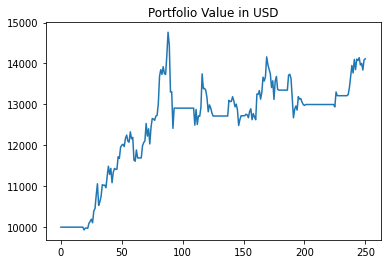

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from datetime import datetime
from tqdm import tqdm

data = yf.download("AAPL",interval="1d",period="1y")

data["SMA_5"] = data["Close"].rolling(window=5).mean()
data["SMA_20"] = data["Close"].rolling(window=20).mean()

data = data.fillna(data.median())

# this function symbolizes the buying process of a long stock
def longBuy(crntMoney,nrStocks,crntPrice):
    # get a whole number of how many stocks we can buy with our money
    howMany = int(crntMoney/crntPrice)
    cost = howMany * crntPrice
    # substract that cost from our current Money
    crntMoney -= cost
    # add the nr of stocks we just bought to out nrStocks tracker
    nrStocks += howMany
    return crntMoney,nrStocks

def longSell(crntMoney,nrStocks,crntPrice):
    # pay out the amount of stocks times current Price
    crntMoney += nrStocks * crntPrice
    nrStocks -= nrStocks # we could set it to 0, but we want to symbolize the trade logic
    return crntMoney,nrStocks

# tqdm is showing us a progress bar, but basically we are just looping through our Close prices in the data array

# reset values
startMoney = 10000
crntMoney = startMoney
nrStocks = 0 

## NEW: portfolioValue
portfolioValue = []

for i,(crntPrice,sma5,sma20) in enumerate(data[["Close","SMA_5","SMA_20"]].values):
    if i > 0:
        crntHoldings = nrStocks
        sma5_yesterday = data["SMA_5"][i-1]
        sma20_yesterday = data["SMA_20"][i-1]

        # start the logic
        if sma5_yesterday <= sma20_yesterday and sma5 > sma20:
            # if sma5 has been below or equal sma20 yesterday, and now it crossed upwards -> upwardstrend
            if crntHoldings == 0: # and we do not have stocks yet
                print(data.index[i]," Buying stock for %.2f$" % crntPrice)
                crntMoney,nrStocks = longBuy(crntMoney,nrStocks,crntPrice)
        elif sma5_yesterday >= sma20_yesterday and sma5 < sma20:
            # if sma5 has been above or equal sma20 yesterday, and now it crossed downwards -> downwardstrend
            if crntHoldings > 0: # can only sell if we have any stocks
                print(data.index[i]," Selling stock for %.2f$" % crntPrice)
                crntMoney,nrStocks = longSell(crntMoney,nrStocks,crntPrice)
        ## NEW: portfolioValue -> use the same logic as our previous final caluclation, just for each day
        portfolioValue.append(crntMoney + (nrStocks * crntPrice))

print("\n\nYour portfolio value is: %.2f$" % portfolioValue[-1])
earnings = portfolioValue[-1] - startMoney
print("Which is a win of: %.2f$" % earnings)

plt.plot(portfolioValue)
plt.title("Portfolio Value in USD")


# preparing our code for parameter tuning

Now what would this result look like if we instead of an SMA of 5 and 20 tried out different settings?
In order to quickly replace these values, we need to replace the number values with "placeholders" that our algorithm can insert. To simplify this process, let us create a function for a run, taking in two parameters (smafast and smaslow), and returning the final gain of the portfolio plus our newly created portfolioValue list.

Basically, I replaced the sma5 and sma20 values with smafast and smaslow, and create the SMA dataframe in the function. Other than that the code is pretty much the same

In [2]:
def runOnce(data,smafast,smaslow):
    # reset values
    startMoney = 10000
    crntMoney = startMoney
    nrStocks = 0 
    
    data["SMA_fast"] = data["Close"].rolling(window=smafast).mean()
    data["SMA_slow"] = data["Close"].rolling(window=smaslow).mean()
    data = data.fillna(data.median())

    portfolioValue = []

    for i,(crntPrice,smafast,smaslow) in enumerate(data[["Close","SMA_fast","SMA_slow"]].values):
        if i > 0:
            crntHoldings = nrStocks
            smafast_yesterday = data["SMA_fast"][i-1]
            smaslow_yesterday = data["SMA_slow"][i-1]

            # start the logic
            if smafast_yesterday <= smaslow_yesterday and smafast > smaslow:
                # if smafast has been below or equal smaslow yesterday, and now it crossed upwards -> upwardstrend
                if crntHoldings == 0: # and we do not have stocks yet
                    # print(data.index[i]," Buying stock for %.2f$" % crntPrice)
                    crntMoney,nrStocks = longBuy(crntMoney,nrStocks,crntPrice)
            elif smafast_yesterday >= smaslow_yesterday and smafast < smaslow:
                # if smafast has been above or equal smaslow yesterday, and now it crossed downwards -> downwardstrend
                if crntHoldings > 0: # can only sell if we have any stocks
                    # print(data.index[i]," Selling stock for %.2f$" % crntPrice)
                    crntMoney,nrStocks = longSell(crntMoney,nrStocks,crntPrice)
            ## NEW: portfolioValue -> use the same logic as our previous final caluclation, just for each day
            portfolioValue.append(crntMoney + (nrStocks * crntPrice))

    # print("\n\nYour portfolio value is: %.2f$" % portfolioValue[-1])
    earnings = portfolioValue[-1] - startMoney
    # print("Which is a win of: %.2f$" % earnings)
    return earnings,portfolioValue

You win is: 4113.19$


Text(0.5, 1.0, 'Portfolio Value in USD')

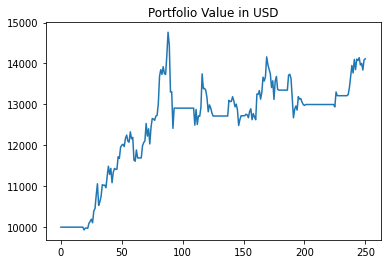

In [3]:
# test our function if it is returning the same result. 
# remark: data.copy() is used to work with a copy of the data

earnings,basic_portfolioValue = runOnce(data.copy(),5,20)
print("You win is: %.2f$" % earnings)

plt.plot(basic_portfolioValue)
plt.title("Portfolio Value in USD")

And voila, same result, but in a handy function that takes in parameters. 

Now let us try out different values, and see which combination gives us the best performance. This can be achieved with two for loops, where we cycle through each combination. We are using tqdm for this operation, which shows us a progressbar of the calculations.

In [4]:
from tqdm import tqdm

SMAFASTS = [2,5,10,20]
SMASLOWS = [10,20,30,50,100]

resultTracker = []

for smafast in tqdm(SMAFASTS):
    for smaslow in SMASLOWS:
        earnings,portfolioValue = runOnce(data.copy(),smafast,smaslow)
        resultTracker.append([earnings,smafast,smaslow,portfolioValue])

# now sort the results written in resultTracker according to the first element (the earnings)
resultTrackerTuned = sorted(resultTracker, key=lambda x: x[0], reverse=True)

print("The best earnings of %.2f$ are achieved with a fast SMA value of %d, and a slow SMA value of %d."%(resultTrackerTuned[0][0],resultTrackerTuned[0][1],resultTrackerTuned[0][2]))



100%|██████████| 4/4 [00:00<00:00, 38.83it/s]

The best earnings of 5401.68$ are achieved with a fast SMA value of 2, and a slow SMA value of 10.


Cool! That is already looking good! At least in my data, the SMA values of 2 and 10 turned out to be 1000+$ better than our previous values of 5 and 20, cool! Let us finally plot the two portfolio lines in comparison

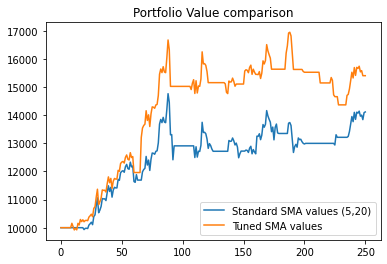

In [5]:
plt.plot(basic_portfolioValue,label="Standard SMA values (5,20)")
plt.plot(resultTrackerTuned[0][3],label="Tuned SMA values")
plt.title("Portfolio Value comparison")
plt.legend()

# Hyperparameter Tuning on steroids

When we plan to test a lot of values we can use helper functions to automatically create a range of testing values and threading to increase the speed of a backtest.

A good hyperparameter tuning model uses random values in a given range, to avoid preassumptions of a person to make it into that model. 
As a rule of thumb, the SMA fast value should be smaller than the slow value for upwards-trending stocks, and the other way around for the other direction. 

In [6]:
from random import sample



SMAFASTS = sample(range(1, 100), 60) # create 30 random values in the range between 1 and 100
SMASLOWS = sample(range(10, 150), 60)

resultTracker = []

for smafast in tqdm(SMAFASTS):
    for smaslow in SMASLOWS:
        earnings,portfolioValue = runOnce(data.copy(),smafast,smaslow)
        resultTracker.append([earnings,smafast,smaslow,portfolioValue])

# now sort the results written in resultTracker according to the first element (the earnings)
resultTrackerHugetest = sorted(resultTracker, key=lambda x: x[0], reverse=True)

print("The best earnings of %.2f$ are achieved with a fast SMA value of %d, and a slow SMA value of %d."%(resultTrackerHugetest[0][0],resultTrackerHugetest[0][1],resultTrackerHugetest[0][2]))


100%|██████████| 60/60 [00:16<00:00,  3.63it/s]

The best earnings of 7276.24$ are achieved with a fast SMA value of 1, and a slow SMA value of 13.


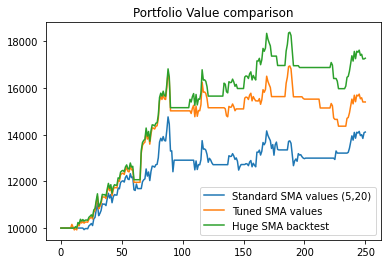

In [7]:
plt.plot(basic_portfolioValue,label="Standard SMA values (5,20)")
plt.plot(resultTrackerTuned[0][3],label="Tuned SMA values")
plt.plot(resultTrackerHugetest[0][3],label="Huge SMA backtest")
plt.title("Portfolio Value comparison")
plt.legend()

Nice! At least in my test the result is way better compared to the previous tests. 
But keep in mind, these will not be the real numbers, we ignored a lot of things which we will cover in the upcoming lections